In [25]:
from lxml import etree
import re
import math
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
%matplotlib inline

In [2]:
class Text(): 
    def __init__(self, filename, lenRange=(2000, 10000), chunks=False): 
        lenMin, lenMax = lenRange
        self.tree = etree.parse(filename)
        self.allSaidElems = self.tree.findall('.//said[@who]')
        # Only get those in our length range
        self.saidElems = [elem for elem in self.allSaidElems if len(elem.text)>lenMin and len(elem.text)<lenMax]
        self.allChars = [elem.attrib['who'] for elem in self.saidElems]
        self.chars = list(set(self.allChars))
        self.labeledText = [(elem.attrib['who'], elem.text) for elem in self.saidElems]
        self.labeledText = [(item[0], self.clean(item[1])) for item in self.labeledText]
        self.labels = [item[0] for item in self.labeledText]
        self.allText = [item[1] for item in self.labeledText]
        self.charDict = self.makeCharDict()
        self.charChunks, self.charChunksLabels = self.makeCharChunks()
        if chunks: 
            self.allText = self.charChunks
            self.labels = self.charChunksLabels
        self.lengths = [len(item) for item in self.allText]
        
    def makeCharDict(self): 
        """ Make a dictionary of each character's total speech. """
        # Initialize empty dictionary. 
        charDict = {char: "" for char in self.chars}
        for elem in self.allSaidElems: 
            charDict[elem.attrib['who']]+=elem.text
        return charDict
            
    def makeCharChunks(self, n=2): 
        """ Make a list of chunks of character speech. """
        charChunks = []
        charChunksLabels = []
        for char, text in self.charDict.items(): 
            #chunks = self.chunkText(text, n)
            chunks = self.sliceText(text)
            for i, chunk in enumerate(chunks): 
                charChunks.append(chunk)
                charChunksLabels.append(char + '-%s' % i)
        return charChunks, charChunksLabels
        
    def chunkText(self, text, n=2): 
        """ Breaks one text into n texts."""
        newLen = math.floor(len(text) / n)
        parts = [text[i:i+newLen] for i in range(0, len(text), newLen)]
        if len(parts) > n: 
            parts[-2]+=parts[-1]
            parts = parts[:n]
        return parts
    
    def sliceText(self, text, size=8000):
        parts = []
        while len(text) > size: 
            part = text[:size]
            text = text[size:]
            parts.append(part)
        return parts

    def clean(self, utterance): 
        """ 
        Cleans utterances. 
        """
        # Remove "said Bernard," etc. 
        charRegex = "said (%s)," % '|'.join(self.chars)
        out = re.sub(charRegex, '', utterance)
       
        # Remove quotation marks. 
        out = re.sub('[“”"]', '', out)
        
        # Remove line breaks. 
        out = re.sub('\n', ' ', out)
        return out

In [3]:
t = Text('waves-tei.xml', lenRange=(5000, 10000))

<IPython.core.display.Javascript object>


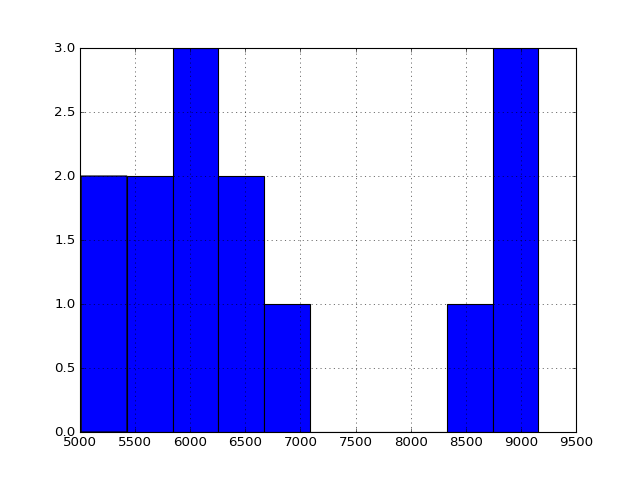

In [4]:
lens = [len(utterance) for utterance in t.allText]
pd.Series(lens).hist()

In [5]:
t.charChunksLabels

['Neville-0',
 'Neville-1',
 'Neville-2',
 'Neville-3',
 'Neville-4',
 'Neville-5',
 'Rhoda-0',
 'Rhoda-1',
 'Rhoda-2',
 'Rhoda-3',
 'Rhoda-4',
 'Susan-0',
 'Susan-1',
 'Susan-2',
 'Susan-3',
 'Louis-0',
 'Louis-1',
 'Louis-2',
 'Louis-3',
 'Louis-4',
 'Louis-5',
 'Bernard-0',
 'Bernard-1',
 'Bernard-2',
 'Bernard-3',
 'Bernard-4',
 'Bernard-5',
 'Bernard-6',
 'Bernard-7',
 'Bernard-8',
 'Bernard-9',
 'Bernard-10',
 'Bernard-11',
 'Bernard-12',
 'Bernard-13',
 'Bernard-14',
 'Bernard-15',
 'Bernard-16',
 'Bernard-17',
 'Bernard-18',
 'Jinny-0',
 'Jinny-1',
 'Jinny-2',
 'Jinny-3']

In [6]:
docs = t.allText

In [7]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.15, max_df=0.4)
tfidfs = tfidf_vectorizer.fit_transform(docs).todense()
df = pd.DataFrame(tfidfs, columns=tfidf_vectorizer.get_feature_names())

In [8]:
df.shape

(14, 455)

In [9]:
def addLabels(df): 
    df['label'] = t.labels
    df['char'] = df['label'].str.split('-').str.get(0)
    df['lengths'] = t.lengths
    df['lengths'] = df['lengths'].divide(df['lengths'].max())
    df['lengths'] = df['lengths'] * 40

In [10]:
# Do latent semantic analysis dimensionality reduction. 
svd = TruncatedSVD(n_components=3)
lsa_out = svd.fit_transform(df)
lsaDF = pd.DataFrame(lsa_out, columns=['x','y', 'z'])
addLabels(lsaDF)

In [11]:
# Do PCA
pca = PCA(n_components=3)
pca_out = pca.fit_transform(df)
pcaDF = pd.DataFrame(pca_out, columns=['x', 'y', 'z'])
addLabels(pcaDF)

In [12]:
def translateColor(label): 
    colorDict = {'B': 'b', 'S': 'g', 'R': 'r', 'N': 'c', 'J': 'y', 'L': 'm'}
    return colorDict[label[0]]

In [13]:
def plotChars(df, dims=2): 
    if dims == 3: 
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    for char in t.chars: 
        charDF = df.loc[df['char'] == char]
        if dims == 2: 
            plt.scatter(charDF['x'], charDF['y'], color=translateColor(char), s=charDF['lengths'], label=char)
            #plt.legend()
        if dims == 3:         
            ax.scatter(charDF['x'], charDF['y'], charDF['z'], color=translateColor(char), 
                       s=charDF['lengths'], label=char)

In [39]:
def doKMeans(df):
    km = KMeans(n_clusters=6)
    fitted = km.fit_transform(df[['x', 'y']])
    means = np.argmax(fitted, axis=1)
    df['mean']=means
    colorMap = 'rgbcmyk'
    for row in df.iterrows(): 
#         print(row[1]['x'])
#         print(row[1]['y'])
#         print(row[1]['mean'])
#         print(colorMap[row[1]['mean']])
        plt.scatter(row[1]['x'], row[1]['y'], color=colorMap[row[1]['mean']])
    return means

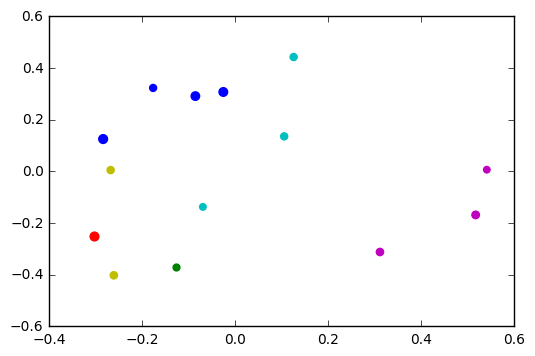

In [40]:
plotChars(pcaDF)

In [41]:
pcaDF.loc[pcaDF['char'] == 'Bernard']

,x,y,z,label,char,lengths,mean
0,-0.085607,0.291679,0.424385,Bernard,Bernard,37.409915,5
1,-0.176492,0.323226,-0.142542,Bernard,Bernard,25.162699,2
5,-0.025526,0.307607,-0.117767,Bernard,Bernard,38.698406,5
10,-0.283947,0.125422,0.265805,Bernard,Bernard,40.000000,2


In [42]:
#plotChars(lsaDF)

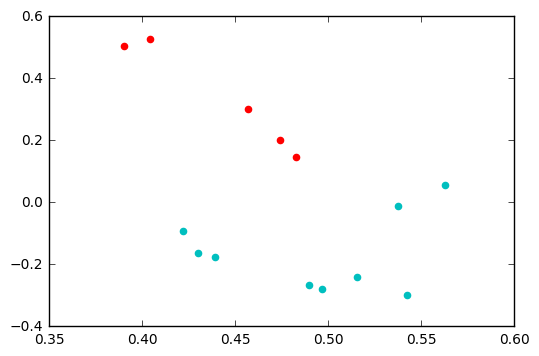

In [78]:
means = doKMeans(lsaDF)

In [79]:
# Express the groups created by K-means in a dictionary, in the form: 
# {0: [7], 1: [0, 5], 2: [9, 11], 3: [1, 3, 4, 6, 8, 10, 13], 5: [2, 12]}
meanDict = {i: [] for i in range(14) if i in means}
for i, mean in enumerate(means): 
    meanDict[mean].append(i)
meanDict

{0: [2, 7, 9, 11, 12], 3: [0, 1, 3, 4, 5, 6, 8, 10, 13]}

In [80]:
def calculateScore(df, meanDict):
    score = 0
    for group, items in meanDict.items(): 
        if len(items) >= 2: 
            chars = df.loc[items]['char']
            counts = chars.value_counts()
            for count in counts: 
                if count > 1: 
                    score += count
    return score

In [82]:
calculateScore(lsaDF, meanDict)

11

In [31]:
#doKMeans(lsaDF)